In [375]:
library("tidyverse")
library("DBI")
library("RSQLite")

# Joining Data

We start by reading and cleaning the cellphone data as in the previous homework, but this time we also pivot the data after it is cleaned. When we pivot the data we convert the columns 1960-2019 into values in the column year and the corresponding number off cellphones to each iso-3 code and is placed in the column n_cellphones.

In [376]:
cellphone_df<-read_csv("data/cell_phones_total.csv",na=c(" ",""))
k_to_expf<-function(x,na.rm=FALSE) parse_number(str_replace_all(x,c(k="e+03",M="e+06",B="e+09")))
lgl_to_num<-function(x ) as.numeric(x)
rplc_na_0<-function(x) replace_na(x,0)
rplc_na_nan<-function(x) replace_na(x,NaN)

cellphone_df<-cellphone_df%>%
group_by(`iso-3`)%>%
mutate_if((is.character),k_to_expf)%>%
mutate_if((is.logical),lgl_to_num)%>%
mutate_at(vars(2:17),rplc_na_0)%>%
mutate_if((is.numeric),rplc_na_nan)%>%
pivot_longer(cols = !`iso-3`,names_to = "year",values_to = "n_cellphones")%>%fill(n_cellphones,.direction = "updown")


Rows: 214 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (41): iso-3, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,...
dbl  (8): 1960, 1965, 1970, 1975, 1976, 1977, 1978, 1979
lgl  (8): 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`mutate_if()` ignored the following grouping variables:
• Column `iso-3`
`mutate_if()` ignored the following grouping variables:
• Column `iso-3`
`mutate_if()` ignored the following grouping variables:
• Column `iso-3`


After reading the file containing information about the number of cellphones we read data about the population in countries, this data is structured in the same way as the data about cellphones but with the population of the country each year instead of the number of cellphones.
The first thing we do with the data is pivoting it by country code, then we fill the missing values using fill in the pipe.

In [377]:
population_df<-read_csv("data/pop_data.csv",na = c(""," "))#

population_df<-population_df%>%pivot_longer(cols = !`iso-3`,names_to = "year",values_to = "population")%>%
fill(population,.direction = "updown")





New names:
• `` -> `...1`
Rows: 266 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): iso-3
dbl (62): ...1, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


When we have read and pivoted the data in both files we can left-join them and then convert the values in the year column into numbers before sorting them in ascending order.

In [378]:
cell_pop_df<-cellphone_df%>%
left_join(population_df)%>%
mutate(year=as.integer(year))%>%
arrange(year)



Joining with `by = join_by(`iso-3`, year)`


Some of the data from the table is presented in a table below.

In [379]:
head(cell_pop_df)

iso-3,year,n_cellphones,population
<chr>,<int>,<dbl>,<dbl>
ABW,1960,0,54608
AFG,1960,0,8622466
AGO,1960,0,5357195
ALB,1960,0,1608800
AND,1960,0,9443
ARE,1960,0,133426


As the iso-3 code for each country is not that descriptive we then read the file country_data.csv containing a bunch of information about countries including their names and iso-3 country codes, but in this file the iso-3 column is instead named alpha-3.

We start by left-joining the new data with the previous data about population and number off cellphones and as the name and iso-3 code of the countries are all we are interested in, we select and rename these column before joining.

Now that we have the names of the countries we can ungroup them by iso-3 and select all rows except the iso-3 code, then we add the column phones_per_capita containing the number of phones divided by the population.

In [380]:
country_df<-read_csv("data/country_data.csv")

cell_pop_df<-cell_pop_df%>%
left_join(country_df%>%
          select(`alpha-3`,name)%>%
          rename(`iso-3`=`alpha-3`) )%>%
ungroup()%>%
select(name,year,n_cellphones,population)%>%
mutate(phones_per_capita=n_cellphones/population)%>%
arrange(phones_per_capita)


Rows: 249 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): name, alpha-2, alpha-3, iso_3166-2, region, sub-region, intermediat...
dbl (4): country-code, region-code, sub-region-code, intermediate-region-code

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(`iso-3`)`


After this we create a new tibble containing only year, name and phones_per_capita before pivoting it so that the first column is the year and the rest are the countries in the data.

In [381]:
cntry_p_cap<-cell_pop_df%>%
select(year,phones_per_capita,name)%>%
pivot_wider(names_from=name,values_from = phones_per_capita)


Then we find the countries with the five highest phones per capita in 2019, and plot the phones per capita of these countries in the last 10 years. As the data ends in 2019 this means the years 2009-2019 are plotted.

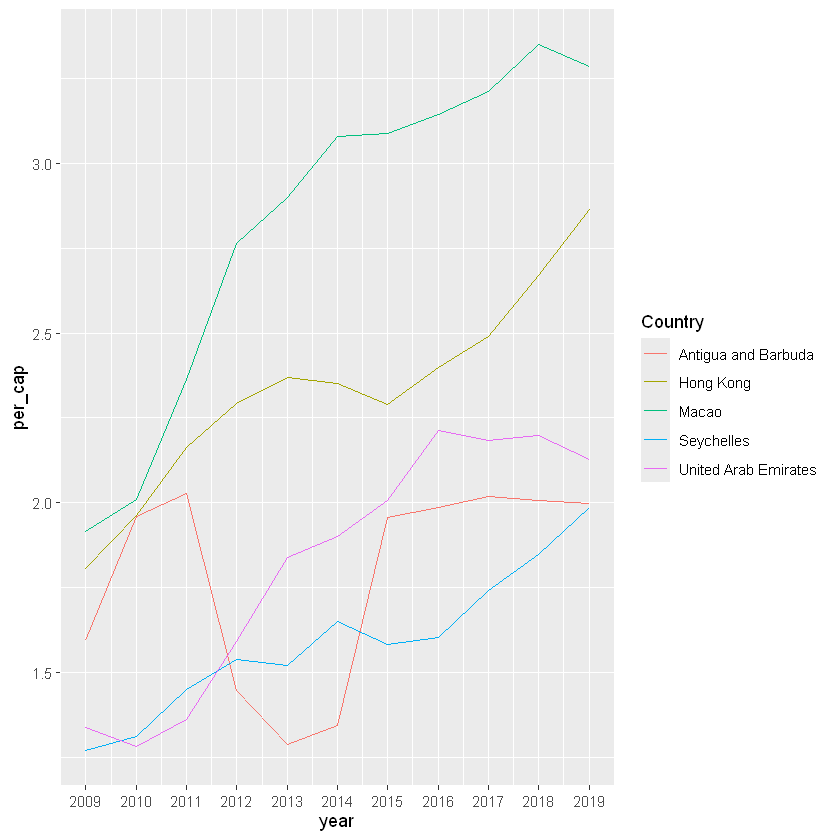

In [382]:
candidate_countries<-cntry_p_cap%>%pivot_longer(cols=!year,values_to="per_cap",names_to = "Country")%>%
filter(year==2019)%>%filter(min_rank(desc(per_cap)) <= 5)

plot_df<-cntry_p_cap%>%pivot_longer(cols=!year,values_to="per_cap",names_to = "Country")%>%
filter(year>=2009,Country %in% (candidate_countries$Country))
ggplot(data=plot_df)+geom_line(mapping=aes(x=year,y=per_cap,color=Country),show.legend = TRUE)+ scale_x_continuous(breaks=seq(2009, 2019, 1))


We can quite clearly see that Macao seems to have the highest growth in phones per capita in the last 10 years.

# SQL
We start by creating a SQL table by reading the user_actions.db file.

In [383]:
table<-dbConnect(RSQLite::SQLite(), "data/user_actions.db")


In order to find users that have performed the signup action, we create a query that from all actions selects the unique usernames of each user that has performed the action "signup" then the query is sorted by user_id just to make it more readable.

In [384]:

dbGetQuery(table, 'SELECT DISTINCT(username) FROM user_actions WHERE action == "signup" ORDER BY user_id;')


username
<chr>
user1
user2
user3
user4
user5
user6
user7
user8
user9


Its not surprising that every user is returned as all of them mustve signed up at some point.

To get the total number of log entries for each user, a query is mad where we select user_id, username and the count of all actions grouped by user_id and username, then once again the results are ordered by user_id so its easier to read.


In [385]:
dbGetQuery(table, 'SELECT user_id,username,COUNT(*) as count 
FROM user_actions 
GROUP BY user_id,username 
ORDER BY user_id;')

user_id,username,count
<int>,<chr>,<int>
1,user1,104
2,user2,149
3,user3,108
4,user4,436
5,user5,192
6,user6,457
7,user7,362
8,user8,329
9,user9,118


From this query we can se that the number of logs vary greatly with each user.

To find all users that have both signed up and logged in on the same day we make two queries act1 and act2. Such that both are either the action "login" or "signup", different from eachother and that these actions occured on the same date.

In [386]:
dbGetQuery(table, '
SELECT DISTINCT(user_id), username
FROM 
    user_actions act1
WHERE EXISTS
(
    SELECT *
    FROM 
        user_actions act2
    WHERE 
        act2.action=="login" OR act2.action=="signup" 
        AND 
        strftime("%Y-%m-%d",act1.timestamp)=strftime("%Y-%m-%d",act2.timestamp) 
        AND
        act1.action!=act2.action
) 
AND 
act1.action="login" OR act1.action ="signup"
ORDER BY user_id;')


user_id,username
<int>,<chr>
1,user1
2,user2
3,user3
4,user4
5,user5
6,user6
7,user7
8,user8
9,user9


Once again its not that surprising that users that have signed up also log in during the same day as there would be no point in signing up if the user did not intend to use the service.

Finally we close the connection to the database before we continue.

In [387]:
dbDisconnect(table, "data/user_actions.db")

# Regex


In order to use regular expression to find different hashtags we start by reading each line from the file comments.txt.

We look closer at the first comment before we try to extract the hashtags from it.

In [388]:
comments<-readLines("data/comments.txt")
cat(comments[1])

1. Great post! #programming #tips

So the hashtags extracted from this comment should be #programing and #tips.

We can the select all strings matching the pattern (#[\w]+) which matches text that starts with # followed by one or more word characters

In [389]:
mod_comment<-str_extract_all(comments,pattern="(#[\\w]+)")
cat(mod_comment[[1]][1],mod_comment[[1]][2])


#programming #tips

As we can see the regular expression matches are the hashtags that we excpected.

In order to return all comments containing both #programming and #tips we start by matching zero or more of all characters that are not " . 
Then we match one or more of either #programming or #python followed by zero or more of any character then we once again match one ore more of either #programming or #python followed by zero or more of any character except ".

We then check if this matches comment two

In [390]:
prog_pyt<-str_extract_all(comments,pattern='[^\"]*(#(python)|#(programming))+.*(#(python)|#(programming))+[^\"]*')
prog_pyt[[2]]


character(0)

Comment two does not match, we therefore check what the commment was

In [391]:
cat(comments[[2]])

2. "Enjoyed the article. #coding #python"

As the comment only contained #python it is correct as it should not have matched. 
But if we look at comment 6 we get

In [392]:
cat(prog_pyt[[6]])

I learned a lot. #programming #python #tips

Which is the correct output as the comment contained both #programming and #python.